# Exploration_SSAC 10 Image Segmentation Project  


* 카메라의 '인물사진 모드' 기술 배경을 학습하고, 적용해보기

**Keyword** : Image Segmentation, Semantic Segmentation, Instance Segmentation, Shallow Focus, DeepLab Algorithm, Depthwise Separable Convolution, Segmentation Limited Point

##### Semantic Segmentation   
이미지 내에 있는 객체들을 의미있는 단위(객체)로 분할하는 작업을 의미하며, **모든 픽셀의 레이블을 예측**하는 Dense Prediction이라고도 불린다.   

##### Instance Segmentation   
Semantic Segmentation이 **모든 픽셀에 대한 레이블(단순한 레이블)** 로 분할하여 예측하는 것이라면, Instance Segmentation은 **픽셀로 분할하여 경계를 만들고, 나누어진 객체(Instance)로 구별** 하는 것이다.   

##### Depthwise Separable Convolution 

![title](Downloads/depthwise_separable_conv.png)   

**Convolution -> Depthwise Convolution -> Depthwise Separable Convolution** 의 단계로 발전하면서 Channel 축을 각각 분리시킨 뒤, Channal 축 길이를 항상 1로 가지는 여러 개의 Convolution 필터를 다시 1 X 1 X C 크기의 Convolution filter를 적용한 것을 의미한다. (다른 말로, filter channel을 1로 압축했다고 표현할 수 있겠다.)

###### Project Process  
1) 배경이 있는 이미지 사진 수집   
2) DeepLab 알고리즘 (Segmentation Model) 로드   
3) 모델 적용하여 피사체와 배경 분리   
4) 배경 흐리게 효과 적용   
5) 흐린 배경과 피사체 다시 합성   
6) 인물모드 한계점 분석

##### 필요한 모듈 import

In [5]:
from IPython.display import Image
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

## Image Version 01.

## 1) 이미지 수집 및 저장

home/ssac22/aiffel/human_segmentation/images/ 저장

In [6]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sunho.png' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(591, 472, 3)


## 2) DeepLabModel 생성

* 현재 Model에 적용되는 Tensorflow V1 으로 적용하여 진행

In [7]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB) # OpenCV -> tensorflow 채널 순서 변경
        img_input = resized_rgb
        return img_input
    
    # 이미지 전처리를 완료하고, 실제 세그멘테이션 진행
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

* 사전에 학습된 가중치 (Pretrained Weight) 로드

In [8]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/ssac22/aiffel/human_segmentation/models
model loaded successfully!


In [9]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(591, 472, 3) (513, 409, 3) 15


* OpenCV shape 표현 순서 : HWC   
* 로드한 image_oirg 크기 : 591 X 472     
* img_resized 크기 : 513 X 409   
* seg_map.max의 값은 15 == Label index를 의미하는데, 여기서는 index 15인 person이 이미지에서 가장 큰 객체로 인식하였다.

* PASCAL VOC 데이터셋으로 학습된 모델의 weight 값이기 때문에, 해당 모델에는 PASCAL VOC의 라벨 값이 적용되어 있다.

In [10]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

## 3) 모델과 라벨 값을 활용하여 피사체 영역 추출

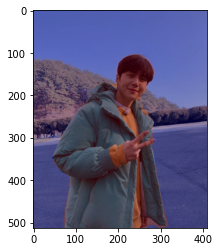

In [11]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출 index15 == person
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

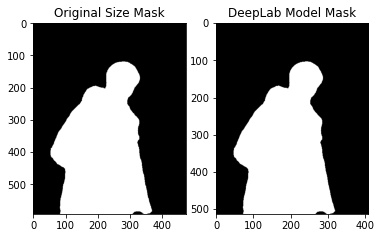

In [12]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

원본과 resize한 이미지 크기가 크게 차이가 안나는 이미지이기 때문에, 좌표 상에 큰 차이는 일어나지 않고 있다.

## 4) 배경 blur 효과 적용

* 상단의 이미지 segmentation의 mask를 활용하여 배경 추출

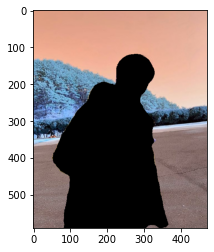

In [13]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # bitwise_not :: 이미지 반전
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

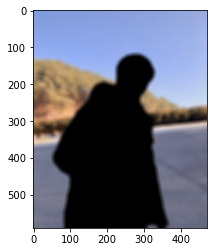

In [14]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 5) 피사체 + 배경 다시 합성

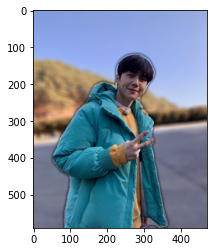

In [15]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [16]:
cv2.imwrite('images/sunhoblur.png', img_concat)

True

##### 원본과 후처리 이미지 비교

<div style="width:48%; height:48%; float:left; margin-right:10px;">
<img src="./aiffel/human_segmentation/images/sunho.png">
</div>
<div style="width:48%; height:48%; float:left;">
<img src="images/sunhoblur.png">
</div>



## Image Version 02.

같은 프로세스로 다른 이미지를 적용해 보기

* 고양이 사진 로드

In [17]:
cat_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png' 
cat_orig = cv2.imread(cat_path) 
print (cat_orig.shape)

(630, 1200, 3)


* 모델을 활용하여, 원본 고양이 사진을 resize시키고, seg_map을 보았을 때, label index == 8 이 고양이를 의미한다.

In [18]:
cat_resized, seg_map = MODEL.run(cat_orig)
print (cat_orig.shape, cat_resized.shape, seg_map.max())

(630, 1200, 3) (269, 513, 3) 8


* label index / seg_map==8 (cat의미) 를 활용하여 사진에서 고양이만 추출하여 mask를 입힌다.

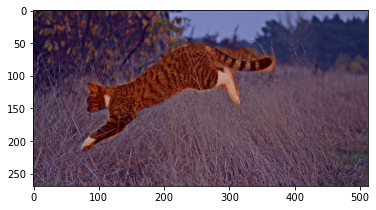

In [19]:
cat_show = cat_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 사람만 추출 index15 == person
cat_mask = seg_map * (255/seg_map.max()) # 255 normalization
cat_mask = cat_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(cat_mask, cv2.COLORMAP_JET)
cat_show = cv2.addWeighted(cat_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(cat_show, cv2.COLOR_BGR2RGB))
plt.show()

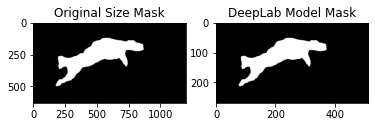

In [20]:
cat_mask_up = cv2.resize(cat_mask, cat_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_mask_up = cv2.threshold(cat_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(cat_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cat_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

resized 하여 축소된 사진을 볼 수 있다.

* 배경에 효과를 넣기 위해 '이미지 반전'을 사용하여 배경을 추출

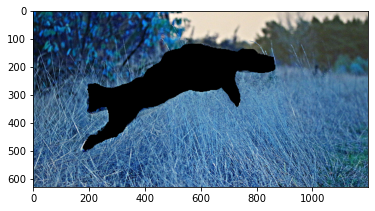

In [21]:
cat_mask_color = cv2.cvtColor(cat_mask_up, cv2.COLOR_GRAY2BGR)
cat_bg_mask = cv2.bitwise_not(cat_mask_color) # bitwise_not :: 이미지 반전
cat_bg = cv2.bitwise_and(cat_orig, cat_bg_mask)
plt.imshow(cat_bg)
plt.show()

* 배경에 blur 효과 처리

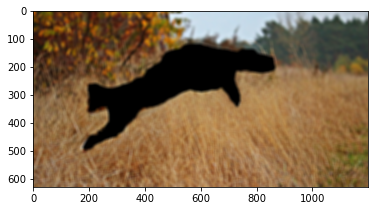

In [22]:
cat_bg_blur = cv2.blur(cat_bg, (13,13))
plt.imshow(cv2.cvtColor(cat_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

* background + mask == 이미지 합치기

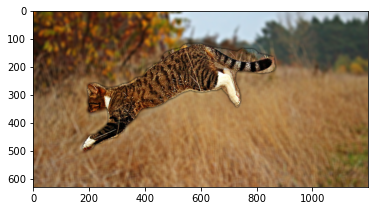

In [23]:
cat_concat = np.where(cat_mask_color==255, cat_orig, cat_bg_blur)
plt.imshow(cv2.cvtColor(cat_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [24]:
cv2.imwrite('images/catblur.png', cat_concat)

True

<div style="width:48%; height:48%; float:left; margin-right:10px;">
<img src="./aiffel/human_segmentation/images/cat.png">
</div>
<div style="width:48%; height:48%; float:left;">
<img src="images/catblur.png">
</div>



## Image Verison 03.

In [25]:
couple_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/couple.jpg' 
couple_orig = cv2.imread(couple_path) 
print (couple_orig.shape)

(512, 341, 3)


In [26]:
couple_resized, seg_map = MODEL.run(couple_orig)
print (couple_orig.shape, couple_resized.shape, seg_map.max())

(512, 341, 3) (513, 341, 3) 15


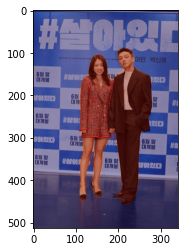

In [27]:
couple_show = couple_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출 index15 == person
couple_mask = seg_map * (255/seg_map.max()) # 255 normalization
couple_mask = couple_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(couple_mask, cv2.COLORMAP_JET)
couple_show = cv2.addWeighted(couple_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(couple_show, cv2.COLOR_BGR2RGB))
plt.show()

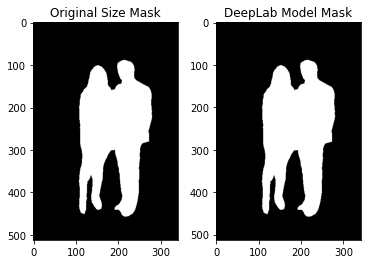

In [28]:
couple_mask_up = cv2.resize(couple_mask, couple_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, couple_mask_up = cv2.threshold(couple_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(couple_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(couple_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

In [34]:
couple_mask_color = cv2.cvtColor(couple_mask_up, cv2.COLOR_GRAY2BGR)

In [29]:
couple_mask_up.shape

(512, 341)

##### 배경으로 가져온 이미지를 원본 이미지 크기와 맞춰주기 위해 PIL 라이브러리 활용

In [33]:
from PIL import Image

img = Image.open('aiffel/human_segmentation/images/travel.jpg')

img_resize = img.resize((341, 512))
img_resize.save('aiffel/human_segmentation/images/recouple.jpg')

img_resize_lanczos = img.resize((341, 512), Image.LANCZOS)
img_resize_lanczos.save('aiffel/human_segmentation/images/lancouple.jpg')

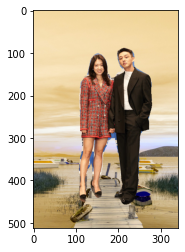

In [38]:
couple_concat = np.where(couple_mask_color==255, couple_orig, img_resize)
plt.imshow(cv2.cvtColor(couple_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [39]:
cv2.imwrite('images/coupletravel.png', couple_concat)

True

<div style="width:48%; height:48%; float:left; margin-right:10px;">
<img src="./aiffel/human_segmentation/images/couple.jpg">
</div>
<div style="width:48%; height:48%; float:left;">
<img src="images/coupletravel.png">
</div>



## Result of Project    

##### Problem of Model      
이미지의 픽셀 단위로 segmentation을 진행하다 보니, 픽셀의 경계선이나 픽셀 중간을 가로지르는 선들을 디테일하게 추출해내지 못하고, 픽셀 단위로 추출하게 되면서 경계가 뚜렷하게 객체를 추출해 내지 못하는 현상이 일어난다.   

또한, 픽셀 edge 부분이나 명암이 흐릿한 경계도 인식하지 못해 색감이 비슷한 부분은 함께 마스크를 씌워 추출해 내기도 하는 것을 발견했다.   


##### Solution        
Adobe의 포토샵과 일러스트레이터의 차이점에서 착안해 보면, 포토샵은 픽셀 기반, 일러스트레이터는 벡터 기반으로 작용하기 때문에 확대를 해도 화질이 깨지거나, 경계선이 뿌렷하게 나타나지 않게 된다. 

그렇기 때문에, segmentation 분야에 픽셀이 아니라 벡터화를 진행한 후 추출을 하게 된다면 경계가 뚜렷하게 추출되지 않을까 생각된다.

또한, 이미지의 edge 부분의 명암을 경계선에 더 뚜렷하게 효과를 넣어서 (mask 자체를 뚜렷하게 추출해 낼 수 있는 방법) 객체를 더 잘 추출해 낼 수 있을 것 같다.   

## Good   
Segmentation에서 객체와 배경을 추출해 내는 방법을 경험하고, 모델을 생성해서 적용하여 레이블에 맞는 객체를 추출해 낼 수 있었다.   

## Difficulties / Challenges   
추출된 객체의 크기를 조정하여 배경에 다중으로 삽입할 수 있는 방법을 찾아서 여러 배경에 객체를 삽입하는 과정을 해보고 싶다.